In [1]:
import pandas as pd 
import numpy as np
import re

##LDA stuff
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##cleaning stuff
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel

##plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns


## Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [3]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    return tokens

In [4]:
def remove_non_english_words(text, valid_words):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() in valid_words]
    return ' '.join(ans)

def remove_stopwords(text):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() not in stop_words]
    return ' '.join(ans)

In [5]:
df_fullerton = pd.read_csv('../../../data/processed/cleaned_fullerton.csv')
df_parkroyal = pd.read_csv('../../../data/processed/cleaned_parkroyal-collection-marina-bay.csv')
df_pan = pd.read_csv('../../../data/processed/cleaned_pan-pacific.csv')
df_mbs = pd.read_csv('../../../data/processed/cleaned_mbs_total.csv')
df_swissotel = pd.read_csv('../../../data/processed/cleaned_swissotel-the-stamford.csv')


df_combi = pd.concat([df_fullerton, df_parkroyal, df_pan, df_mbs, df_swissotel])

In [6]:
##filter for year >= 2015
df_filtered = df_combi[df_combi['date'] >= '2015-01-01']

##preprocess text
nltk.download('stopwords')
nltk.download('words')
# Get the list of valid English words
english_words = set(words.words())
# set stopwords
sw = stopwords.words('english')
sw.extend(['fullerton', 'parkroyal', 'collection', 'marina', 'marina_bay', 'pacific', 'pan', 'pan_pacific', 'mbs', 'bay_sands', 
          'swissotel', 'stamford', 'star'])
stop_words = set(sw)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## Stemmed

In [7]:
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_stopwords)
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['stem_tokens'] = df_filtered['stem_review'].apply(preprocess)

In [8]:
##Generate LDA dictionary and corpus
#stem_dict = corpora.Dictionary(df_filtered['stem_tokens']) #use if we want to rerun
#stem_dict.save('5star_stem')
stem_dict = corpora.Dictionary.load('5star_stem')
stem_corpus = [stem_dict.doc2bow(text) for text in df_filtered['stem_tokens']]

In [ ]:
## find best_coherence (Don't run, takes too long to run):
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    stem_ldamodel = lda(stem_corpus, num_topics=i, id2word=stem_dict, passes=15, random_state=0)
    
    stem_coherence = CoherenceModel(model=stem_ldamodel, texts=df_filtered['tokens'], dictionary=stem_dict, coherence='c_v')
    lda_coherence = stem_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

In [9]:
## Use 5 topics as baseline
lda = gensim.models.ldamodel.LdaModel
stem_ldamodel = lda(stem_corpus, num_topics=6, id2word=stem_dict, passes=15, random_state=0)

In [10]:
# For all topics
topics_stem = stem_ldamodel.show_topics(formatted=False, num_words=20)
data_flat_stem = [word for word_list in df_filtered['stem_tokens'] for word in word_list]

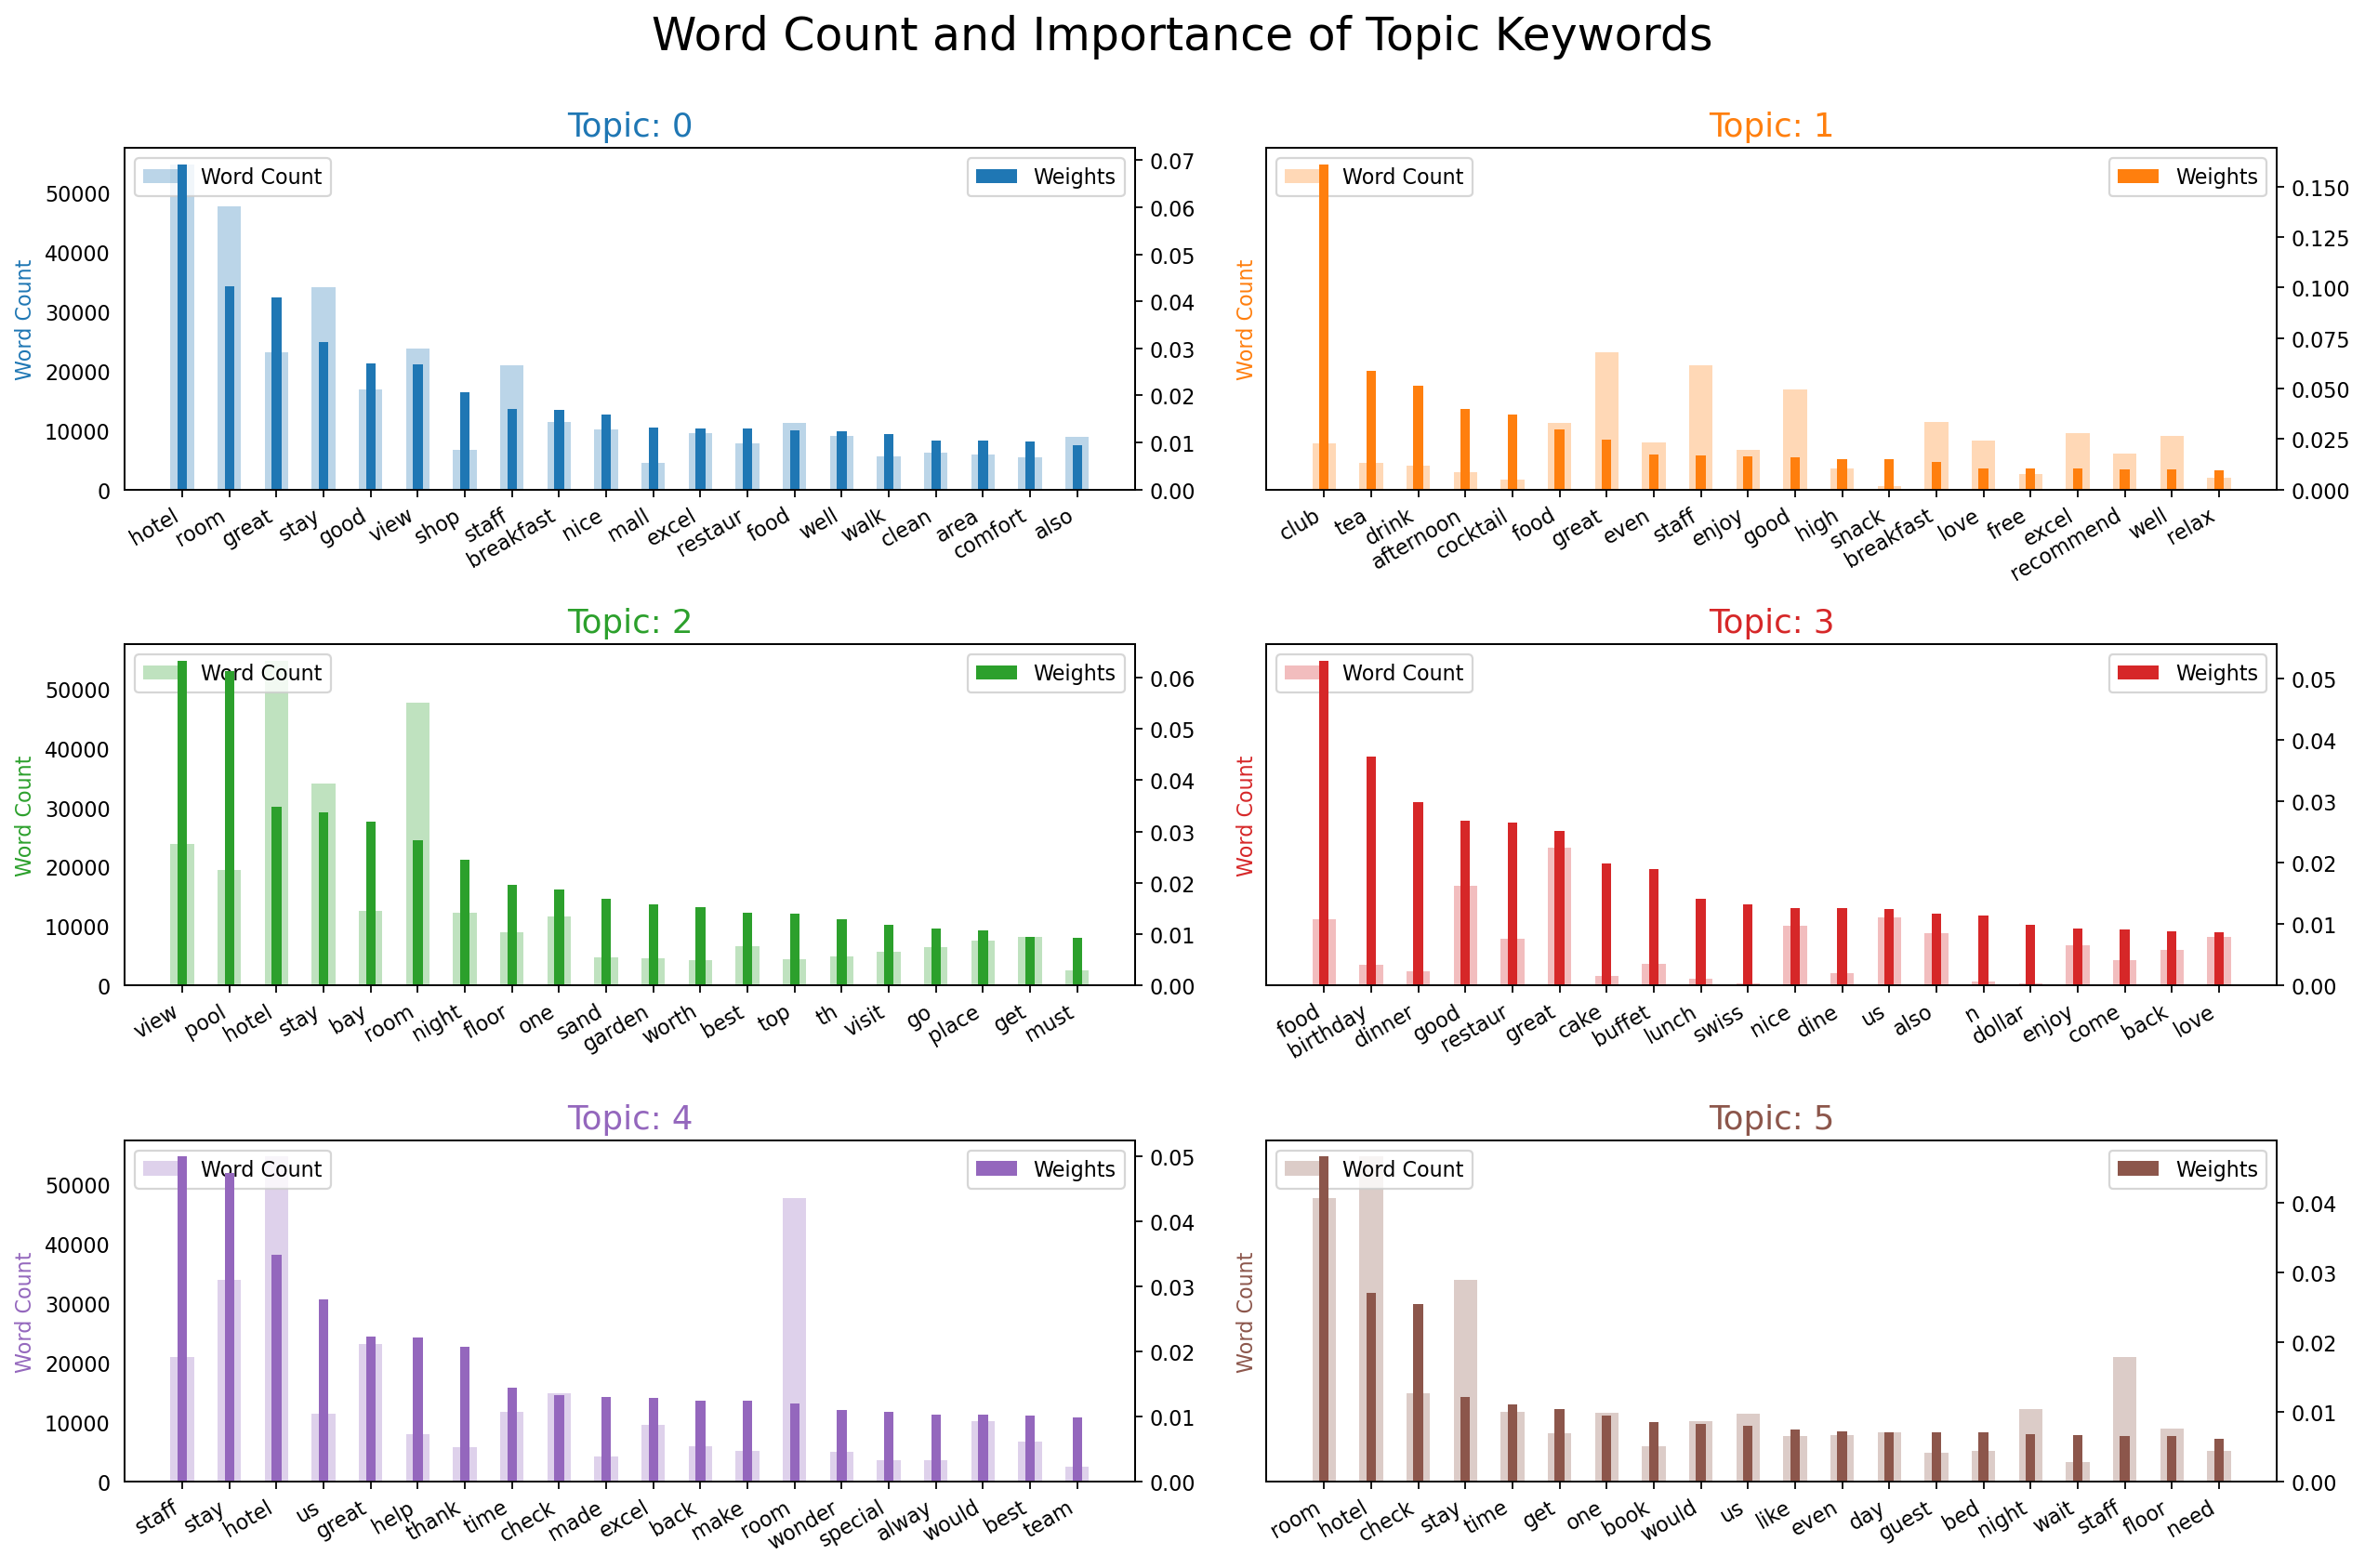

In [11]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_stem, data_flat_stem, 'Word Count and Importance of Topic Keywords')

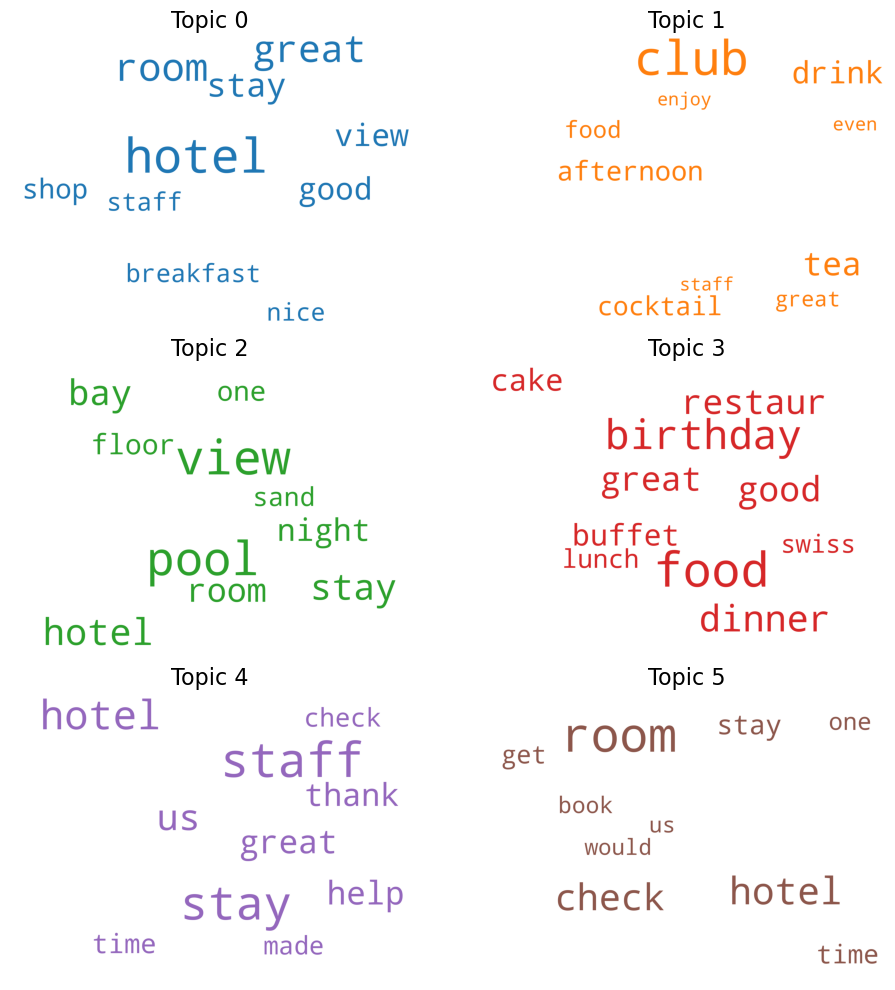

In [12]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(6):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(stem_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for pre-COVID topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [13]:
vis = pyLDAvis.gensim.prepare(topic_model=stem_ldamodel, corpus=stem_corpus, dictionary=stem_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Lemmatized

In [14]:
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_stopwords)
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['lem_tokens'] = df_filtered['lem_review'].apply(preprocess)

In [15]:
##Generate LDA dictionary and corpus
lem_dict = corpora.Dictionary(df_filtered['lem_tokens'])
lem_dict.save('5star_lem')
lem_dict = corpora.Dictionary.load('5star_lem')
lem_corpus = [lem_dict.doc2bow(text) for text in df_filtered['lem_tokens']]

In [24]:
## find best_coherence:
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    lem_ldamodel = lda(lem_corpus, num_topics=i, id2word=lem_dict, passes=15, random_state=0)
    
    lem_coherence = CoherenceModel(model=lem_ldamodel, texts=df_filtered['lem_tokens'], dictionary=lem_dict, coherence='c_v')
    lda_coherence = lem_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.3393086211143098
The coherence score at topic 3 is 0.35634143140643476
The coherence score at topic 4 is 0.37072653573468917
The coherence score at topic 5 is 0.37408171120809947
The coherence score at topic 6 is 0.40324437306184996


In [16]:
## Use 5 topics as baseline
lda = gensim.models.ldamodel.LdaModel
lem_ldamodel = lda(lem_corpus, num_topics=6, id2word=lem_dict, passes=15, random_state=0)

In [17]:
# For All
topics_lem = lem_ldamodel.show_topics(formatted=False)
data_flat_lem = [word for word_list in df_filtered['lem_tokens'] for word in word_list]

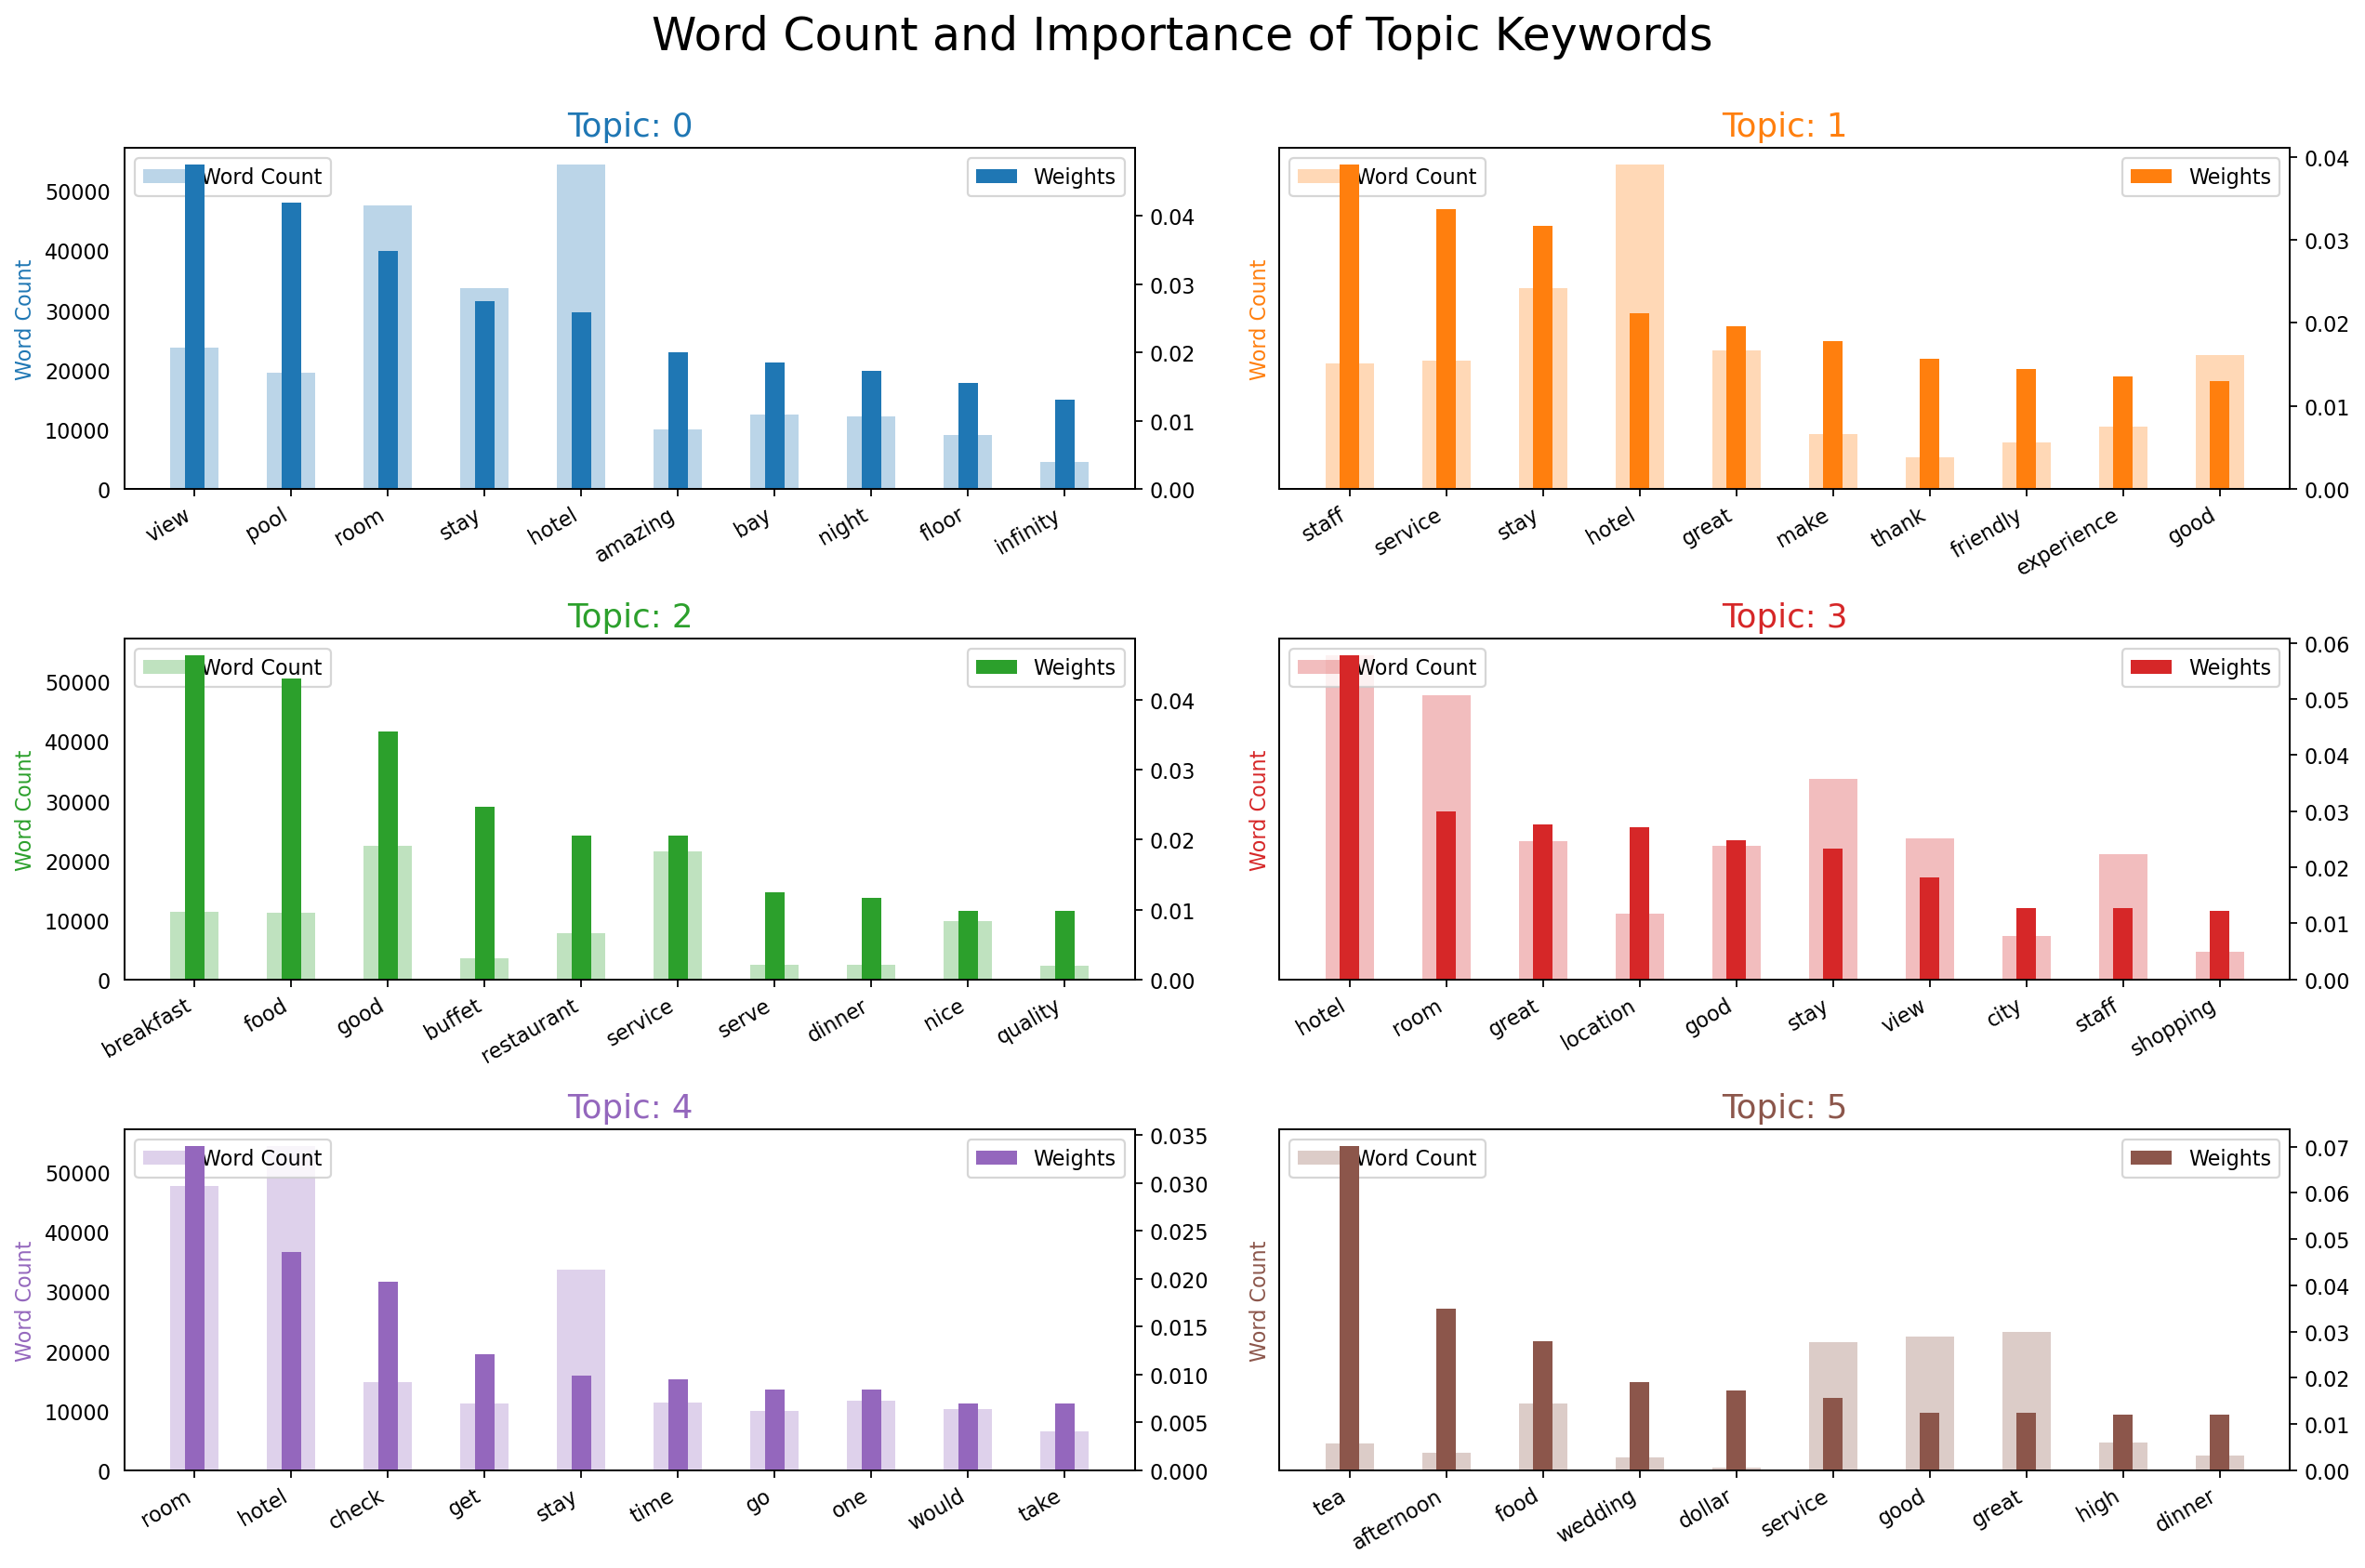

In [18]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For Pre-COVID
plot_word_count_importance(topics_lem, data_flat_lem, 'Word Count and Importance of Topic Keywords')

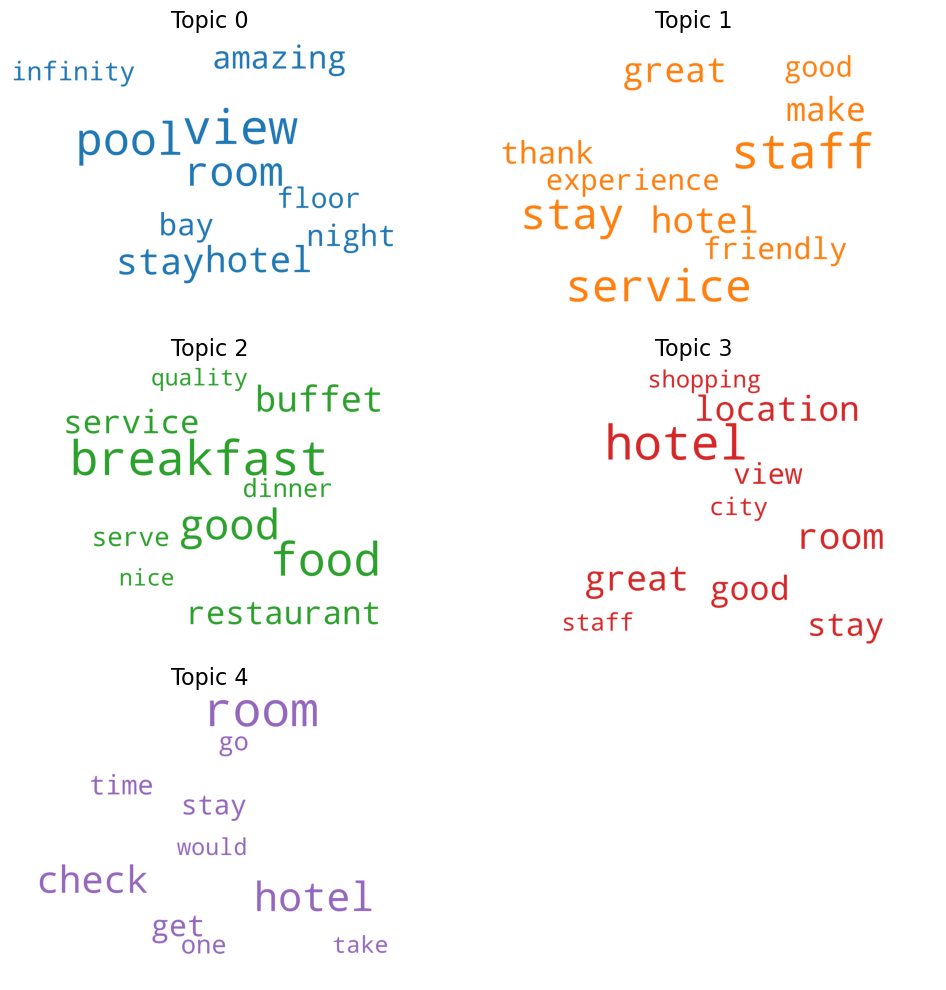

In [19]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the pre-COVID dataset
clouds_pre = []

for i in range(5):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(lem_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for topics
fig_pre, axes_pre = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [20]:
vis = pyLDAvis.gensim.prepare(topic_model=lem_ldamodel, corpus=lem_corpus, dictionary=lem_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Get Topics

In [21]:
topics_stem

[(0,
  [('hotel', 0.06911704),
   ('room', 0.04318725),
   ('great', 0.040856153),
   ('stay', 0.031329904),
   ('good', 0.026788272),
   ('view', 0.026653612),
   ('shop', 0.020756159),
   ('staff', 0.017083755),
   ('breakfast', 0.016935417),
   ('nice', 0.015988665),
   ('mall', 0.0131834755),
   ('excel', 0.012981376),
   ('restaur', 0.012915415),
   ('food', 0.012654273),
   ('well', 0.012416333),
   ('walk', 0.011805787),
   ('clean', 0.010495572),
   ('area', 0.010311405),
   ('comfort', 0.010213382),
   ('also', 0.0094832545)]),
 (1,
  [('club', 0.1610574),
   ('tea', 0.05872025),
   ('drink', 0.051452283),
   ('afternoon', 0.03976836),
   ('cocktail', 0.03691459),
   ('food', 0.02955796),
   ('great', 0.024905043),
   ('even', 0.017410452),
   ('staff', 0.016674459),
   ('enjoy', 0.016487569),
   ('good', 0.015987394),
   ('high', 0.015053509),
   ('snack', 0.014916568),
   ('breakfast', 0.013775884),
   ('love', 0.01057486),
   ('free', 0.0103764245),
   ('excel', 0.010246777

In [22]:
top_dict = {}
for i in topics_stem:
    top_dict[i[0]] = []
    for j in i[1]:
        print(j)
        top_dict[i[0]].append(j[0])

('hotel', 0.06911704)
('room', 0.04318725)
('great', 0.040856153)
('stay', 0.031329904)
('good', 0.026788272)
('view', 0.026653612)
('shop', 0.020756159)
('staff', 0.017083755)
('breakfast', 0.016935417)
('nice', 0.015988665)
('mall', 0.0131834755)
('excel', 0.012981376)
('restaur', 0.012915415)
('food', 0.012654273)
('well', 0.012416333)
('walk', 0.011805787)
('clean', 0.010495572)
('area', 0.010311405)
('comfort', 0.010213382)
('also', 0.0094832545)
('club', 0.1610574)
('tea', 0.05872025)
('drink', 0.051452283)
('afternoon', 0.03976836)
('cocktail', 0.03691459)
('food', 0.02955796)
('great', 0.024905043)
('even', 0.017410452)
('staff', 0.016674459)
('enjoy', 0.016487569)
('good', 0.015987394)
('high', 0.015053509)
('snack', 0.014916568)
('breakfast', 0.013775884)
('love', 0.01057486)
('free', 0.0103764245)
('excel', 0.010246777)
('recommend', 0.010136923)
('well', 0.0097751785)
('relax', 0.009698872)
('view', 0.063311145)
('pool', 0.061264258)
('hotel', 0.034756053)
('stay', 0.033663

In [23]:
top_dict

{0: ['hotel',
  'room',
  'great',
  'stay',
  'good',
  'view',
  'shop',
  'staff',
  'breakfast',
  'nice',
  'mall',
  'excel',
  'restaur',
  'food',
  'well',
  'walk',
  'clean',
  'area',
  'comfort',
  'also'],
 1: ['club',
  'tea',
  'drink',
  'afternoon',
  'cocktail',
  'food',
  'great',
  'even',
  'staff',
  'enjoy',
  'good',
  'high',
  'snack',
  'breakfast',
  'love',
  'free',
  'excel',
  'recommend',
  'well',
  'relax'],
 2: ['view',
  'pool',
  'hotel',
  'stay',
  'bay',
  'room',
  'night',
  'floor',
  'one',
  'sand',
  'garden',
  'worth',
  'best',
  'top',
  'th',
  'visit',
  'go',
  'place',
  'get',
  'must'],
 3: ['food',
  'birthday',
  'dinner',
  'good',
  'restaur',
  'great',
  'cake',
  'buffet',
  'lunch',
  'swiss',
  'nice',
  'dine',
  'us',
  'also',
  'n',
  'dollar',
  'enjoy',
  'come',
  'back',
  'love'],
 4: ['staff',
  'stay',
  'hotel',
  'us',
  'great',
  'help',
  'thank',
  'time',
  'check',
  'made',
  'excel',
  'back',
  'm

In [24]:
df_res = pd.DataFrame(top_dict)
df_res

,0,1,2,3,4,5
0,hotel,club,view,food,staff,room
1,room,tea,pool,birthday,stay,hotel
2,great,drink,hotel,dinner,hotel,check
3,stay,afternoon,stay,good,us,stay
4,good,cocktail,bay,restaur,great,time
5,view,food,room,great,help,get
6,shop,great,night,cake,thank,one
7,staff,even,floor,buffet,time,book
8,breakfast,staff,one,lunch,check,would
9,nice,enjoy,sand,swiss,made,us


In [25]:
df_res.to_csv('5-star LDA.csv')

## DP

In [26]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [27]:
# Pass in LDA topics output to remove overlap words by choosing highest prob
def restruct_topics(topics): 
    word_prob_dict = {}
    for i in range(len(topics)):
        topic_num = topics[i][0]
        for word, prob in topics[i][1]:
            if word in word_prob_dict:
                word_prob_dict[word].append((topic_num, prob))
            else:
                ls = [(topic_num, prob)]
                word_prob_dict[word] = ls
    new_dict = {}
    for word in word_prob_dict:
        topic, highest_prob = max(word_prob_dict[word], key = lambda x: x[1])
        if topic in new_dict:
            new_dict[topic].append(word)
        else:
            ls = [word]
            new_dict[topic] = ls
    return new_dict

In [28]:
new_dict = restruct_topics(topics_stem)

In [29]:
new_dict = restruct_topics(topics_stem)
for x in new_dict:
    print(f'length topic {x}: {len(new_dict[x])}')

length topic 0: 12
length topic 5: 10
length topic 4: 14
length topic 3: 14
length topic 2: 16
length topic 1: 13


In [30]:
#takes in the dataframe and appends to each row (aspect, review) pair(s)
def dep_parse(data, new_dict):
    data['aspect_sentiment'] = np.empty((len(data), 0)).tolist()
    for i in range(len(data)):
        sentence = data['combined_review'][i]
        doc = nlp(sentence)
        aspect_sentiment = []
        for word in doc:
            cond = False
            for x in new_dict.values():
                if word.text in x:
                    cond = True
                    break
            if not cond:
                continue
            if word.pos_ == 'NOUN': 
                for j in word.lefts:
                    #print(j, word, j.dep_, j.pos_)
                    if j.dep_ == 'amod' and j.pos_ == 'ADJ':
                        tup = [word, j, list(new_dict.values()).index(x)]
                        #print(tup)
                        aspect_sentiment.append(tup)
                    for k in j.lefts:
                        if k.dep_ == 'advmod':
                            #print(word, j ,k)
                            tup = (word, k.text + ' ' + j.text)
                            aspect_sentiment.append(tup)
                            if (word, j) in aspect_sentiment:
                                aspect_sentiment.remove([word, j, list(new_dict.values()).index(x)])
        data['aspect_sentiment'][i] = aspect_sentiment

In [31]:
df_filtered = df_filtered.reset_index()

In [50]:
dep_parse(df_filtered, new_dict)

In [51]:
df_filtered['aspect_sentiment']

0                                                       []
1            [[hotel, Best, 0], [breakfast, delicious, 0]]
2                                        [[stay, nice, 2]]
3         [[place, exclusive, 4], (place, more exclusive)]
4                                        [[time, next, 2]]
                               ...                        
35617    [[stay, recent, 2], (stay, most recent), (hote...
35618    [[view, sensational, 4], [floor, 40th, 4], [vi...
35619    [[view, great, 4], [room, decent, 1], [room, l...
35620                               [[hotel, Ordinary, 0]]
35621    [[floor, 57th, 4], [day, first, 1], [room, sma...
Name: aspect_sentiment, Length: 35622, dtype: object

In [53]:
df_filtered

,index,travel_type,rating,label,combined_review,date,covid,is_local,stem_review,lem_review,cleaned_review,stem_tokens,lem_tokens,vec_tokens,aspect_sentiment
0,0,couple,5.0,Positive,Sall...the man at the pool! Sall was so kind a...,2023-09-01,PostCovid,0,man pool kind thought time went pool want exac...,man pool kind thoughtful every time go pool ab...,sall man pool sall kind thoughtful every time ...,"[man, pool, kind, thought, time, went, pool, w...","[man, pool, kind, thoughtful, every, time, go,...",man pool kind thought time went pool want exac...,[]
1,1,couple,NaN,NaN,Best luxury hotel in Singapore This has to rat...,2023-03-01,PostCovid,0,best hotel rate one best hotel stay around wor...,good luxury hotel rate one good hotel stay aro...,best luxury hotel singapore rate one best hote...,"[best, hotel, rate, one, best, hotel, stay, ar...","[good, luxury, hotel, rate, one, good, hotel, ...",best hotel rate one best hotel stay around wor...,"[[hotel, Best, 0], [breakfast, delicious, 0]]"
2,2,business,5.0,Positive,Concierge team at Fullerton This hotel is abso...,2023-08-01,PostCovid,0,team hotel perfect nice yet comfort stay ideal...,concierge team hotel absolutely perfect nice c...,concierge team fullerton hotel absolutely perf...,"[team, hotel, perfect, nice, yet, comfort, sta...","[concierge, team, hotel, absolutely, perfect, ...",team hotel perfect nice yet comfort stay ideal...,"[[stay, nice, 2]]"
3,3,business,5.0,Positive,PERFECTION My husband and I are frequent trave...,2023-08-01,PostCovid,0,perfect husband frequent travel stay bay sand ...,perfection husband frequent traveler stay bay ...,perfection husband frequent travelers singapor...,"[perfect, husband, frequent, travel, stay, bay...","[perfection, husband, frequent, traveler, stay...",perfect husband frequent travel stay bay sand ...,"[[place, exclusive, 4], (place, more exclusive)]"
4,4,business,5.0,Positive,A warm welcome from the hotel I had a business...,2023-09-01,PostCovid,0,warm hotel trip got flu hotel staff met strait...,warm welcome hotel business trip get flu arriv...,warm welcome hotel business trip got flu arriv...,"[warm, hotel, trip, got, flu, hotel, staff, me...","[warm, welcome, hotel, business, trip, get, fl...",warm hotel trip got flu hotel staff met strait...,"[[time, next, 2]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35617,5149,business,2.0,Negative,Swiss Hotel but service ain't Swiss I have sta...,2015-01-01,PreCovid,0,swiss hotel swiss stay hotel mani time recent ...,swiss hotel service swiss stay hotel many time...,swiss hotel service swiss stayed hotel many ti...,"[swiss, hotel, swiss, stay, hotel, mani, time,...","[swiss, hotel, service, swiss, stay, hotel, ma...",swiss hotel swiss stay hotel mani time recent ...,"[[stay, recent, 2], (stay, most recent), (hote..."
35618,5150,couple,5.0,Positive,So Happy I Stayed There Stayed for 6 nights wi...,2015-01-01,PreCovid,0,stay stay night wife ideal view th floor floor...,happy stay stay night wife ideal location sens...,happy stayed stayed nights wife ideal location...,"[stay, stay, night, wife, ideal, view, th, flo...","[happy, stay, stay, night, wife, ideal, locati...",stay stay night wife ideal view th floor floor...,"[[view, sensational, 4], [floor, 40th, 4], [vi..."
35619,5151,couple,4.0,Positive,"great view, great location, decent large room ...",2015-01-01,PreCovid,0,great view great decent room one night hotel v...,great view great location decent large room on...,great view great location decent large room on...,"[great, view, great, decent, room, one, night,...","[great, view, great, location, decent, large, ...",great view great decent room one night hotel v...,"[[view, great, 4], [room, decent, 1], [room, l..."
35620,5168,couple,1.0,Negative,Ordinary This hotel is dated and old. Four nig...,2015-01-01,PreCovid,0,hotel date old four night mani cup machin shop...,ordinary hotel date old four night many plus c...,ordinary hotel dated old four nights many plus.

In [52]:
df_filtered.to_csv('5star-DP.csv')

## Import PyABSA

In [32]:
df_test = pd.read_json('../pyABSA_outputs/Aspect_Term_Extraction_and_Polarity_Classification_FAST_LCF_ATEPC.json')

In [33]:
df_test

,sentence,IOB,tokens,aspect,position,sentiment,probs,confidence
0,clean comfort hotel room find decent hotel tra...,"[O, B-ASP, O, O, O, O, O, O, O, B-ASP, O, O, O...","[clean, comfort, hotel, room, find, decent, ho...","[comfort, food, glass, closet space, port]","[[1], [9], [30], [37, 38], [47]]","[Positive, Negative, Negative, Negative, Negat...","[[0.022732432931661002, 0.002103362465277, 0.9...","[0.9752000000000001, 0.922, 0.8991, 0.86620000..."
1,good hotel great great place great room small ...,"[O, O, O, O, B-ASP, O, O, O, O, O, O, O, O, O,...","[good, hotel, great, great, place, great, room...",[place],[[4]],[Positive],"[[0.0005702517228200001, 0.0003066391509490000...",[0.9991000000000001]
2,good place decent price good place good price ...,"[O, O, O, B-ASP, O, O, O, O, O, O, O, O, B-ASP...","[good, place, decent, price, good, place, good...","[price, food]","[[3], [12]]","[Positive, Negative]","[[0.005487654823809001, 0.013030127622187, 0.9...","[0.9815, 0.912]"
3,great great staff neat hotel line star rate st...,"[O, O, B-ASP, O, O, O, O, O, O, B-ASP, I-ASP, ...","[great, great, staff, neat, hotel, line, star,...","[staff, front desk]","[[2], [9, 10]]","[Positive, Positive]","[[0.032106801867485005, 0.00041079759830600003...","[0.9675, 0.9994000000000001]"
4,good budget stay stay day nice seven eleven ne...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[good, budget, stay, stay, day, nice, seven, e...",[wait],[[18]],[Positive],"[[0.408927053213119, 0.019343916326761003, 0.5...",[0.5717]
...,...,...,...,...,...,...,...,...
68287,swiss hotel swiss stay hotel mani time recent ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[swiss, hotel, swiss, stay, hotel, mani, time,...","[size, staff, porter, crew]","[[15], [35], [67], [78]]","[Negative, Negative, Negative, Negative]","[[0.998076200485229, 0.001359648769721, 0.0005...","[0.9981000000000001, 0.9958, 0.9956, 0.9973000..."
68288,stay stay night wife ideal view th floor floor...,"[O, O, O, O, O, B-ASP, O, O, O, O, O, O, O, O,...","[stay, stay, night, wife, ideal, view, th, flo...","[view, staff, air]","[[5], [25], [45]]","[Positive, Positive, Positive]","[[0.09106669574975901, 0.0005153458332640001, ...","[0.9084000000000001, 0.8150000000000001, 0.9484]"
68289,great view great decent room one night hotel v...,"[O, B-ASP, O, O, B-ASP, O, O, O, O, O, O, O, O...","[great, view, great, decent, room, one, night,...","[view, room, bathroom]","[[1], [4], [23]]","[Positive, Positive, Positive]","[[0.000963231665082, 0.000514330400619, 0.9985...","[0.9985, 0.9973000000000001, 0.9973000000000001]"
68290,hotel date old four night mani cup machin shop...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, B-ASP,...","[hotel, date, old, four, night, mani, cup, mac...","[bed, cover]","[[13], [18]]","[Positive, Positive]","[[0.07999674975872001, 0.000742122647352, 0.91...","[0.9193, 0.6769000000000001]"


In [34]:
df_json = df_test[df_test['sentence'].isin(list(df_filtered['stem_review']))]

In [35]:
len(df_json) == len(df_filtered) ##check if the number of elements is the same

False

In [36]:
df_json = df_json[['sentence', 'tokens', 'aspect', 'sentiment', 'confidence']]

In [37]:
df_json

,sentence,tokens,aspect,sentiment,confidence
32670,man pool kind thought time went pool want exac...,"[man, pool, kind, thought, time, went, pool, w...",[pool],[Negative],[0.8258000000000001]
32671,best hotel rate one best hotel stay around wor...,"[best, hotel, rate, one, best, hotel, stay, ar...","[room, staff]","[Negative, Negative]","[0.998, 0.9956]"
32672,team hotel perfect nice yet comfort stay ideal...,"[team, hotel, perfect, nice, yet, comfort, sta...",[comfort],[Positive],[0.9785]
32673,perfect husband frequent travel stay bay sand ...,"[perfect, husband, frequent, travel, stay, bay...","[look, comfort place, staff]","[Positive, Negative, Negative]","[0.9711000000000001, 0.5018, 0.5366000000000001]"
32674,warm hotel trip got flu hotel staff met strait...,"[warm, hotel, trip, got, flu, hotel, staff, me...",[staff],[Negative],[0.9908]
...,...,...,...,...,...
68287,swiss hotel swiss stay hotel mani time recent ...,"[swiss, hotel, swiss, stay, hotel, mani, time,...","[size, staff, porter, crew]","[Negative, Negative, Negative, Negative]","[0.9981000000000001, 0.9958, 0.9956, 0.9973000..."
68288,stay stay night wife ideal view th floor floor...,"[stay, stay, night, wife, ideal, view, th, flo...","[view, staff, air]","[Positive, Positive, Positive]","[0.9084000000000001, 0.8150000000000001, 0.9484]"
68289,great view great decent room one night hotel v...,"[great, view, great, decent, room, one, night,...","[view, room, bathroom]","[Positive, Positive, Positive]","[0.9985, 0.9973000000000001, 0.9973000000000001]"
68290,hotel date old four night mani cup machin shop...,"[hotel, date, old, four, night, mani, cup, mac...","[bed, cover]","[Positive, Positive]","[0.9193, 0.6769000000000001]"


## Get PyABSA topics

In [38]:
def get_topics(lst, dictionary, sentiment, confidence, topics_list, vectorizer, transformer, model):
    ans = []
    for word in range(len(lst)):
        docbow = dictionary.doc2bow([lst[word]])
        if len(docbow) == 0:
            tpc = get_cosine_similarity(lst[word], topics_list, vectorizer, transformer)
            res = (tpc, sentiment[word], confidence[word])
        else:
            tpc = model.get_document_topics(docbow)
            new_tpc = []
            max_val = 0
            max_tpc = -1
            for c, v in tpc:
                if v > max_val:
                    max_val = v
                    max_tpc = c
            res = (max_tpc, sentiment[word], confidence[word])
        ans.append(res)
    return ans

In [39]:
def get_cosine_similarity(word, topics_list, vectorizer, transformer):
    aspect_vec = vectorizer.transform([word])
    aspect_trf = transformer.transform(aspect_vec)
    cos_res = {}
    for i in range(len(topics_list.columns)):
        topic_words_vec = vectorizer.transform(list(topics_list[i]))
        topic_words_trf = transformer.transform(topic_words_vec)
        r = cosine_similarity(aspect_trf, topic_words_trf)
        cos_sim = np.rad2deg(np.arccos(r))
        
        mid_res = []
        for j in cos_sim:
            min_cos_sim = min(j)
            mid_res.append(min_cos_sim)
        cos_res[i] = mid_res
    min_val = 90
    min_topic = -1
    for k, v in cos_res.items():
        if v[0] < min_val:
            min_val = v
            min_topic = k
    return k

In [40]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import scipy.sparse

In [41]:
df_filtered['vec_tokens'] = df_filtered['stem_tokens'].apply(lambda x: ' '.join(x))

In [42]:
vectorizer = CountVectorizer()
transformer = TfidfTransformer()

filtered_vec = vectorizer.fit_transform(df_filtered['vec_tokens'])
filtered_trf = transformer.fit_transform(filtered_vec)

In [43]:
df_json['topics'] = np.empty((len(df_json), 0)).tolist()

In [44]:
df_json

,sentence,tokens,aspect,sentiment,confidence,topics
32670,man pool kind thought time went pool want exac...,"[man, pool, kind, thought, time, went, pool, w...",[pool],[Negative],[0.8258000000000001],[]
32671,best hotel rate one best hotel stay around wor...,"[best, hotel, rate, one, best, hotel, stay, ar...","[room, staff]","[Negative, Negative]","[0.998, 0.9956]",[]
32672,team hotel perfect nice yet comfort stay ideal...,"[team, hotel, perfect, nice, yet, comfort, sta...",[comfort],[Positive],[0.9785],[]
32673,perfect husband frequent travel stay bay sand ...,"[perfect, husband, frequent, travel, stay, bay...","[look, comfort place, staff]","[Positive, Negative, Negative]","[0.9711000000000001, 0.5018, 0.5366000000000001]",[]
32674,warm hotel trip got flu hotel staff met strait...,"[warm, hotel, trip, got, flu, hotel, staff, me...",[staff],[Negative],[0.9908],[]
...,...,...,...,...,...,...
68287,swiss hotel swiss stay hotel mani time recent ...,"[swiss, hotel, swiss, stay, hotel, mani, time,...","[size, staff, porter, crew]","[Negative, Negative, Negative, Negative]","[0.9981000000000001, 0.9958, 0.9956, 0.9973000...",[]
68288,stay stay night wife ideal view th floor floor...,"[stay, stay, night, wife, ideal, view, th, flo...","[view, staff, air]","[Positive, Positive, Positive]","[0.9084000000000001, 0.8150000000000001, 0.9484]",[]
68289,great view great decent room one night hotel v...,"[great, view, great, decent, room, one, night,...","[view, room, bathroom]","[Positive, Positive, Positive]","[0.9985, 0.9973000000000001, 0.9973000000000001]",[]
68290,hotel date old four night mani cup machin shop...,"[hotel, date, old, four, night, mani, cup, mac...","[bed, cover]","[Positive, Positive]","[0.9193, 0.6769000000000001]",[]


In [45]:
for i, r in df_json.iterrows():
    asp = r['aspect']
    sent = r['sentiment']
    confid = r['confidence']
    tpc = get_topics(asp, stem_dict, sent, confid, df_res, vectorizer, transformer, stem_ldamodel)
    tpcs = r['topics']
    for i in tpc:
        tpcs.append(i)
    r['topics'] = tpcs

In [46]:
print(f"The number of reviews without any topics is {sum(df_json['topics'].apply(lambda x: len(x) == 0))}")
print(f"The number of reviews with exactly one topic is {sum(df_json['topics'].apply(lambda x: len(x) == 1))}")
print(f"The number of reviews with more than one topic is {sum(df_json['topics'].apply(lambda x: len(x) > 1))}")

The number of reviews without any topics is 1655
The number of reviews with exactly one topic is 9007
The number of reviews with more than one topic is 24928


In [47]:
df_json

,sentence,tokens,aspect,sentiment,confidence,topics
32670,man pool kind thought time went pool want exac...,"[man, pool, kind, thought, time, went, pool, w...",[pool],[Negative],[0.8258000000000001],"[(2, Negative, 0.8258000000000001)]"
32671,best hotel rate one best hotel stay around wor...,"[best, hotel, rate, one, best, hotel, stay, ar...","[room, staff]","[Negative, Negative]","[0.998, 0.9956]","[(5, Negative, 0.998), (4, Negative, 0.9956)]"
32672,team hotel perfect nice yet comfort stay ideal...,"[team, hotel, perfect, nice, yet, comfort, sta...",[comfort],[Positive],[0.9785],"[(0, Positive, 0.9785)]"
32673,perfect husband frequent travel stay bay sand ...,"[perfect, husband, frequent, travel, stay, bay...","[look, comfort place, staff]","[Positive, Negative, Negative]","[0.9711000000000001, 0.5018, 0.5366000000000001]","[(2, Positive, 0.9711000000000001), (5, Negati..."
32674,warm hotel trip got flu hotel staff met strait...,"[warm, hotel, trip, got, flu, hotel, staff, me...",[staff],[Negative],[0.9908],"[(4, Negative, 0.9908)]"
...,...,...,...,...,...,...
68287,swiss hotel swiss stay hotel mani time recent ...,"[swiss, hotel, swiss, stay, hotel, mani, time,...","[size, staff, porter, crew]","[Negative, Negative, Negative, Negative]","[0.9981000000000001, 0.9958, 0.9956, 0.9973000...","[(0, Negative, 0.9981000000000001), (4, Negati..."
68288,stay stay night wife ideal view th floor floor...,"[stay, stay, night, wife, ideal, view, th, flo...","[view, staff, air]","[Positive, Positive, Positive]","[0.9084000000000001, 0.8150000000000001, 0.9484]","[(2, Positive, 0.9084000000000001), (4, Positi..."
68289,great view great decent room one night hotel v...,"[great, view, great, decent, room, one, night,...","[view, room, bathroom]","[Positive, Positive, Positive]","[0.9985, 0.9973000000000001, 0.9973000000000001]","[(2, Positive, 0.9985), (5, Positive, 0.997300..."
68290,hotel date old four night mani cup machin shop...,"[hotel, date, old, four, night, mani, cup, mac...","[bed, cover]","[Positive, Positive]","[0.9193, 0.6769000000000001]","[(0, Positive, 0.9193), (5, Positive, 0.676900..."


In [48]:
df_json.to_csv('5star_pyABSA_updated.csv')